# EDA for UNSW-NB15 Data Set

In [2]:
import pandas as pd
import numpy as np

import matplotlib.pyplot as plt
%matplotlib inline

# Modeling Imports
from sklearn.decomposition import PCA
from sklearn.preprocessing import OneHotEncoder

from sklearn.ensemble import RandomForestClassifier, IsolationForest
from sklearn.svm import OneClassSVM

from sklearn.metrics import confusion_matrix, roc_auc_score

In [3]:
data = pd.read_csv('./data/UNSW_NB15_testing-set.csv', header=0, index_col=0)
len(data.columns)

44

In [39]:
data.columns

Index(['dur', 'proto', 'service', 'state', 'spkts', 'dpkts', 'sbytes',
       'dbytes', 'rate', 'sttl', 'dttl', 'sload', 'dload', 'sloss', 'dloss',
       'sinpkt', 'dinpkt', 'sjit', 'djit', 'swin', 'stcpb', 'dtcpb', 'dwin',
       'tcprtt', 'synack', 'ackdat', 'smean', 'dmean', 'trans_depth',
       'response_body_len', 'ct_srv_src', 'ct_state_ttl', 'ct_dst_ltm',
       'ct_src_dport_ltm', 'ct_dst_sport_ltm', 'ct_dst_src_ltm',
       'is_ftp_login', 'ct_ftp_cmd', 'ct_flw_http_mthd', 'ct_src_ltm',
       'ct_srv_dst', 'is_sm_ips_ports', 'attack_cat', 'label'],
      dtype='object')

Note that IP address and port numbers are not included in the data set, and that we've used the id column as an index.
* id
* srcip
* sport
* dstip
* dsport  

This brings us to 44 data columns that we'll have to use as features.

In [45]:
n_obs = data.shape[0]
print(n_obs)

175341


In [46]:
# Number of invalid data
data.isnull().sum().sum()

0

In [47]:
data.attack_cat.unique()

array(['Normal', 'Backdoor', 'Analysis', 'Fuzzers', 'Shellcode',
       'Reconnaissance', 'Exploits', 'DoS', 'Worms', 'Generic'],
      dtype=object)

In [48]:
mask = data.label == 1
print("No. of attacks:", data[mask].label.size)
print("No. of normal: ", data[~mask].label.size)

No. of attacks: 119341
No. of normal:  56000


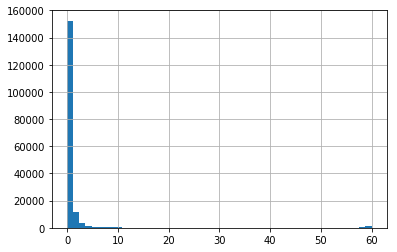

In [49]:
data.dur.hist(bins=50)

In [50]:
for col in data.columns:
    print(col, len(data[col].unique()))

dur 74039
proto 133
service 13
state 9
spkts 480
dpkts 443
sbytes 7214
dbytes 6660
rate 76991
sttl 11
dttl 6
sload 80885
dload 77474
sloss 409
dloss 370
sinpkt 76161
dinpkt 74245
sjit 77532
djit 76831
swin 13
stcpb 75265
dtcpb 75089
dwin 7
tcprtt 43319
synack 40142
ackdat 37708
smean 1357
dmean 1328
trans_depth 11
response_body_len 2386
ct_srv_src 52
ct_state_ttl 5
ct_dst_ltm 50
ct_src_dport_ltm 47
ct_dst_sport_ltm 32
ct_dst_src_ltm 54
is_ftp_login 4
ct_ftp_cmd 4
ct_flw_http_mthd 11
ct_src_ltm 50
ct_srv_dst 52
is_sm_ips_ports 2
attack_cat 10
label 2


In [52]:
data.is_ftp_login.value_counts()

0    172774
1      2545
4        16
2         6
Name: is_ftp_login, dtype: int64

In [122]:
data.proto.value_counts()

tcp           79946
udp           63283
unas          12084
arp            2859
ospf           2595
sctp           1150
any             300
gre             225
swipe           201
pim             201
mobile          201
ipv6            201
sun-nd          201
rsvp            200
sep             193
ib              101
vmtp            100
wb-mon          100
br-sat-mon      100
wb-expak        100
srp             100
ipip            100
ipcomp          100
ipx-n-ip        100
crudp           100
ttp             100
sdrp            100
iatp            100
sat-mon         100
gmtp            100
              ...  
leaf-1           99
ip               99
prm              99
dcn              99
st2              99
chaos            99
ggp              99
leaf-2           99
trunk-1          99
emcon            99
mux              99
irtp             99
igp              99
trunk-2          99
iso-tp4          99
pup              99
cbt              99
ipnip            99
xns-idp          99


In [55]:
data.state.unique()

array(['FIN', 'INT', 'CON', 'ECO', 'REQ', 'RST', 'PAR', 'URN', 'no'],
      dtype=object)

In [58]:
data.service.unique()

array(['-', 'ftp', 'smtp', 'snmp', 'http', 'ftp-data', 'dns', 'ssh',
       'radius', 'pop3', 'dhcp', 'ssl', 'irc'], dtype=object)

In [59]:
data.sttl.unique()

array([252,  62, 254,   0,   1,  31,  63,  64,  60,  29, 255])

<class 'pandas.core.frame.DataFrame'>
Int64Index: 175341 entries, 1 to 175341
Data columns (total 44 columns):
dur                  175341 non-null float64
proto                175341 non-null object
service              175341 non-null object
state                175341 non-null object
spkts                175341 non-null int64
dpkts                175341 non-null int64
sbytes               175341 non-null int64
dbytes               175341 non-null int64
rate                 175341 non-null float64
sttl                 175341 non-null int64
dttl                 175341 non-null int64
sload                175341 non-null float64
dload                175341 non-null float64
sloss                175341 non-null int64
dloss                175341 non-null int64
sinpkt               175341 non-null float64
dinpkt               175341 non-null float64
sjit                 175341 non-null float64
djit                 175341 non-null float64
swin                 175341 non-null int64
stcpb     

# Modeling Efforts:
* One-hot encoding  
* PCA
* Random Forest Classifier
* Isolation Forest
* One-Class SVM

In [114]:
ohe = OneHotEncoder(sparse=False)
state_ohe = ohe.fit_transform(data.state.values.reshape(-1,1))

In [115]:
state_ohe.toarray()

array([[0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       [0., 0., 1., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]])

In [116]:
ohe.categories_

[array(['CON', 'ECO', 'FIN', 'INT', 'PAR', 'REQ', 'RST', 'URN', 'no'],
       dtype=object)]

In [120]:
state_df = pd.DataFrame(state_ohe.toarray(),index=data.index, columns= ohe.categories_[0])

In [121]:
data.merge(state_df, right_index=True, left_index=True)

,dur,proto,service,state,spkts,dpkts,sbytes,dbytes,rate,sttl,...,label,CON,ECO,FIN,INT,PAR,REQ,RST,URN,no
id,,,,,,,,,,,,,,,,,,,,,
1,0.121478,tcp,-,FIN,6,4,258,172,74.087490,252,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
2,0.649902,tcp,-,FIN,14,38,734,42014,78.473372,62,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
3,1.623129,tcp,-,FIN,8,16,364,13186,14.170161,62,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
4,1.681642,tcp,ftp,FIN,12,12,628,770,13.677108,62,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
5,0.449454,tcp,-,FIN,10,6,534,268,33.373826,254,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
6,0.380537,tcp,-,FIN,10,6,534,268,39.417980,254,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
7,0.637109,tcp,-,FIN,10,8,534,354,26.683033,254,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
8,0.521584,tcp,-,FIN,10,8,534,354,32.593026,254,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0
9,0.542905,tcp,-,FIN,10,8,534,354,31.313031,254,...,0,0.0,0.0,1.0,0.0,0.0,0.0,0.0,0.0,0.0


In [71]:
X = data.select_dtypes(exclude='object').iloc[:,:-1]
y = data.label

In [123]:
len(X.columns)

39

In [88]:
rfc = RandomForestClassifier()
rfc.fit(X,y)

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/forest.py:248: FutureWarning: The default value of n_estimators will change from 10 in version 0.20 to 100 in 0.22.
  "10 in version 0.20 to 100 in 0.22.", FutureWarning)


RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=10, n_jobs=None,
            oob_score=False, random_state=None, verbose=0,
            warm_start=False)

In [91]:
print(roc_auc_score(y, rfc.predict(X)))
confusion_matrix(y, rfc.predict(X))

0.9958843069888567


array([[ 55677,    323],
       [   294, 119047]])

In [72]:
ilf = IsolationForest()

In [124]:
ilf.fit(X[~mask])

/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:214: FutureWarning: default contamination parameter 0.1 will change in version 0.22 to "auto". This will change the predict method behavior.
  FutureWarning)
/anaconda3/lib/python3.6/site-packages/sklearn/ensemble/iforest.py:224: FutureWarning: behaviour="old" is deprecated and will be removed in version 0.22. Please use behaviour="new", which makes the decision_function change to match other anomaly detection algorithm API.
  FutureWarning)


IsolationForest(behaviour='old', bootstrap=False, contamination='legacy',
        max_features=1.0, max_samples='auto', n_estimators=100,
        n_jobs=None, random_state=None, verbose=0)

In [125]:
# Isolation Forest outputs -1 and 1, change this to 0 and 1
y_pred = ilf.predict(X[mask])
y_pred = (y_pred>0).astype(int)


In [134]:
pd.Series(y_pred).value_counts()

1    62612
0    56729
dtype: int64

In [129]:
#print(roc_auc_score(y[mask], y_pred))
confusion_matrix(y[mask], y_pred)

array([[    0,     0],
       [56729, 62612]])

In [101]:
pca_10 = PCA(n_components=2)
data_2d = pca_10.fit_transform(X)

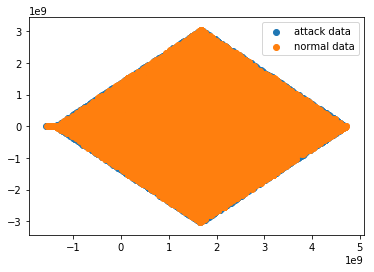

In [130]:
plt.scatter(data_2d[mask,0], data_2d[mask,1], label = 'attack data')
plt.scatter(data_2d[~mask,0], data_2d[~mask,1], label = 'normal data')
plt.legend()

In [105]:
data_2d.shape

(175341, 2)

Basic One Class SVM

NameError: name 'X' is not defined